<a href="https://colab.research.google.com/github/AnshumanJaysingh/memb-MD-analysis/blob/main/membrane_dynamics/CG_scc_order.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install lipyphilic


In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


In [ ]:
import pathlib
import pickle

import numpy as np
import matplotlib.pyplot as plt

import MDAnalysis as mda
from lipyphilic.lib.order_parameter import SCC
from lipyphilic.lib.assign_leaflets import AssignLeaflets, AssignCurvedLeaflets


In [ ]:
top="/content/gdrive/Shareddrives/1bct_5zim_bR/lipid_order/em.tpr"
traj="/content/gdrive/Shareddrives/1bct_5zim_bR/lipid_order/corr_md.xtc"
u = mda.Universe(top,traj)


In [ ]:
leaflets = AssignLeaflets(
    universe=u,
    lipid_sel="name GL1 GL2 ROH"  # atom selection covering all lipids in the bilayer
)

In [ ]:
leaflets.run(
    start=None,
    stop=None,
    step=None,
    verbose=True
)

  0%|          | 0/5001 [00:00<?, ?it/s]

In [ ]:
leaflets.leaflets.shape

(453, 5001)

In [ ]:
first_lipid = leaflets.leaflets[0]
first_lipid

array([1, 1, 1, ..., 1, 1, 1], dtype=int8)

In [ ]:
membrane = u.select_atoms("name GL1 GL2 ROH").residues  # the selection is the same passed to AssignLeaflets
membrane.n_residues

<Residue DPPC, 70>

In [ ]:
membrane[2]

<Residue DPPC, 72>

In [ ]:
mask = membrane.resnames == "DPPC"
leaflets.leaflets[mask].shape


(453, 5001)

In [ ]:
leaflets.leaflets[mask]


array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [ 1,  1,  1, ...,  1,  1,  1],
       [-1, -1, -1, ..., -1, -1, -1],
       [ 1,  1,  1, ...,  1,  1,  1]], dtype=int8)

In [ ]:
leaflets.filter_leaflets(
    lipid_sel="resname DPPC",  # select DPPC and DOPC only
    start=None,
    stop=None,
    step=10
).shape

(453, 501)

In [ ]:
results_directory = pathlib.Path(
    "results/leaflets"
)

# Create the directory if it doesn't already exist
results_directory.resolve().mkdir(exist_ok=True, parents=True)

In [ ]:
# Location to store the results
filename = results_directory.joinpath("leaflets.pkl")
print(filename)

results/leaflets/leaflets.pkl


In [ ]:
# store the object
with open(filename, 'wb') as f:
    pickle.dump(leaflets, f)

In [ ]:
# load for later usage
with open(filename, 'rb') as f:
    leaflets = pickle.load(f)

In [ ]:
# Location to store the results
filename = results_directory.joinpath("leaflets.npy")
print(filename)

results/leaflets/leaflets.npy


In [ ]:
# store the results array only
np.save(filename, leaflets.leaflets)

In [ ]:
# load for later usage
leaflets_data = np.load(filename)

# Scc ORDER PARAMETER

In [ ]:
leaflets = AssignLeaflets(
    universe=u,
    lipid_sel="name GL1 GL2 ROH"  # atom selection covering all lipids in the bilayer
)

In [ ]:
scc_sn1 = SCC(
    universe = u, 
    tail_sel = "name ??A"
)

In [ ]:
scc_sn1.run(start=None, stop=None, step=None, verbose=True)

  0%|          | 0/5001 [00:00<?, ?it/s]

scc_sn1.SCC.shape

In [ ]:
scc_sn2 = SCC(
    universe = u, 
    tail_sel = "name ??B"
)

scc_sn2.run(start=None, stop=None, step=None, verbose=True)


  0%|          | 0/5001 [00:00<?, ?it/s]

In [ ]:
scc = SCC.weighted_average(scc_sn1, scc_sn2)  

In [ ]:
with open("results/leaflets/leaflets.pkl", 'rb') as f:
    leaflets = pickle.load(f)
    

In [ ]:
phospholipid_leaflets = leaflets.filter_leaflets(
    lipid_sel="resname DPPC"
)

In [ ]:
leaflet_mask = (phospholipid_leaflets == 1)

In [ ]:
leaflet_mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True]])

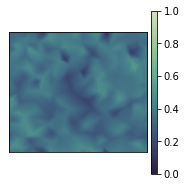

In [ ]:
scc_UL = scc.project_SCC(
    lipid_sel="name GL1 GL2",  # select phospholipid atoms for calculating the COM of each lipid
    filter_by=leaflet_mask,    # use only lipids in the upper leaflet
    start=-20                  # use Scc values from 100 frames from the end onwards, otherwise the whole trajectory will be used
)

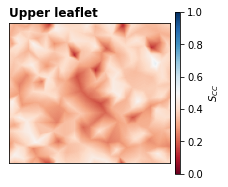

In [ ]:
# set the size of our plot (in inches)
fig, ax = plt.subplots(1, figsize=(3.5, 3.5))

scc_UL.plot_projection(
    ax=ax,                  # where to plot the plot
    title="Upper leaflet",
    vmin=0.0,               # colourbar maximum value
    vmax=1,                 # colourbar minimum value
    cmap="RdBu",            # colourmap to use
    cbar_kws={"shrink": 0.85, "label": r"$S_{CC}$"}  # make the colourbar smaller and give it a label
)

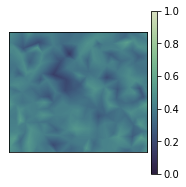

In [ ]:
leaflet_mask_LL = (phospholipid_leaflets == -1)

scc_LL = scc.project_SCC(
    lipid_sel="name GL1 GL2",  # select phospholipid atoms for calculating the COM of each lipid
    filter_by=leaflet_mask_LL,    # use only lipids in the upper leaflet
    start=-20                  # use Scc values from 100 frames from the end onwards, otherwise the whole trajectory will be used
)

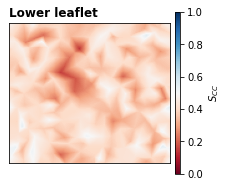

In [ ]:
# set the size of our plot (in inches)
fig, ax = plt.subplots(1, figsize=(3.5, 3.5))

scc_LL.plot_projection(
    ax=ax,                  # where to plot the plot
    title="Lower leaflet",
    vmin=0.0,               # colourbar maximum value
    vmax=1,                 # colourbar minimum value
    cmap="RdBu",            # colourmap to use
    cbar_kws={"shrink": 0.85, "label": r"$S_{CC}$"}  # make the colourbar smaller and give it a label
)